In [239]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Classificadores:
from sklearn.neighbors import NearestNeighbors
# Regressor:
from sklearn.linear_model import LinearRegression
# Metricas:
from sklearn.metrics import mean_squared_error, r2_score

## 1) Carregando os dados

In [240]:
dados = pd.read_csv("..\Dados\Tabela_final\municipios_clusters.csv", index_col=0)

In [241]:
dados.head()

,IBGE7,UF,NOME,LATITUDE,LONGITUDE,DIST_EF_PUB,DIST_EM_PUB,IDEB_AI,IDEB_AF,DOCSUP_EF_PUB,...,T_ANALF25M,ANO,RDPC,QUAL_MED_AGUA,TRANSPORT_COST,TOT_ESC_POR_POP,TOT_MAT_POR_POP,DIST_CAPITAL,CAPITAL_PROX,CLUSTER
0,2700300,AL,ARAPIRACA,-9.75487,-36.6615,28.884,43.100,4.580,3.624,54.40,...,28.61,2010.0,8917.20,62.486900,24042.166072,0.000433,0.245423,102.025981,MACEIO,2
1,2700706,AL,BATALHA,-9.67420,-37.1330,31.100,35.892,4.544,3.632,12.62,...,40.54,2010.0,4027.68,62.486900,24257.110578,0.001200,0.384829,137.500525,ARACAJU,3
2,2700904,AL,BELO MONTE,-9.82272,-37.2770,36.412,54.792,3.928,3.044,27.12,...,49.99,2010.0,5285.37,52.964055,24226.863743,0.002235,0.298063,122.950205,ARACAJU,1
3,2701209,AL,CACIMBINHAS,-9.40121,-36.9911,38.284,40.720,4.164,3.324,49.04,...,51.12,2010.0,4112.70,62.486900,24358.206538,0.001102,0.419781,140.854338,MACEIO,1
4,2701605,AL,CANAPI,-9.11932,-37.5967,31.024,38.636,4.584,3.580,20.84,...,51.97,2010.0,3568.46,74.933851,24734.221802,0.002032,0.366838,207.272744,ARACAJU,1


## 2) Análise de Correlação

In [242]:
# Correlation Matrix:
def heatmap_cor(df):
    cor = df.corr()
    mascara = np.zeros_like(cor)
    mascara[np.triu_indices_from(mascara)] = True
    sns.heatmap(cor, mask=mascara, cbar=True, annot=True, cmap="crest")

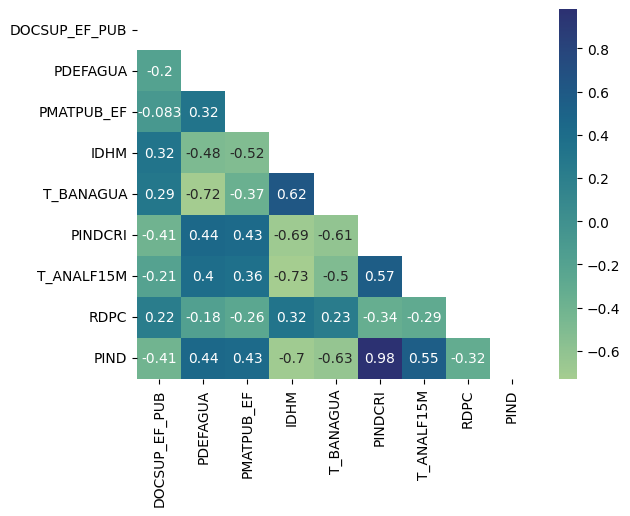

In [243]:
colunas_avaliadas = ['DOCSUP_EF_PUB',
                            'PDEFAGUA',
                            'PMATPUB_EF',
                            'IDHM',
                            'T_BANAGUA',
                            'T_ANALF15M',
                            'RDPC',
                            'PIND']

heatmap_cor(dados[colunas_avaliadas])

## 3) Pré-processamento

In [244]:
def remocao_outliers(df, columns):
    result = df.copy()

    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        result[column] = result[column].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)

    knn_imputer = KNNImputer(n_neighbors=5)
    dados_imputados = knn_imputer.fit_transform(result[columns])
    return dados_imputados

In [245]:
X = dados[['DOCSUP_EF_PUB',
        'PDEFAGUA',
        'PMATPUB_EF',
        'IDHM',
        'T_BANAGUA',
        'T_ANALF15M',
        'RDPC', 
        'CLUSTER']]

y = dados["PIND"].values

In [246]:
# Tratando outliers:
colunas_numericas = [i for i in X.columns if i != "CLUSTER"]
X.loc[:, colunas_numericas] = remocao_outliers(X, colunas_numericas)

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [248]:
min_max = MinMaxScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[colunas_numericas] = min_max.fit_transform(X_train[colunas_numericas])
X_test_scaled[colunas_numericas] = min_max.transform(X_test[colunas_numericas])

## 3) Modelagem da variável Percentual de Extremamente Pobres (PIND)

In [249]:
def avaliacao(y_test, y_pred):    
    # Avaliação:
    mse = mean_squared_error(y_test, y_pred) 
    r2 = r2_score(y_test, y_pred)
    print(f"Mean squared error: {mse}")
    print(f"Root Mean squared error: {np.sqrt(mse)}")
    print(f"R2 score: {r2}")

### 3.1) Regressão Linear

In [250]:
modelo_linear = LinearRegression()
modelo_linear.fit(X_train_scaled, y_train)

LinearRegression()

In [251]:
y_pred_linear = modelo_linear.predict(X_test_scaled)
avaliacao(y_test, y_pred_linear)

Mean squared error: 32.311624121672146
Root Mean squared error: 5.684331457759316
R2 score: 0.5818384665711592


### 3.2) Random Forest

In [252]:
modelo_rnd = RandomForestRegressor(random_state=42)
modelo_rnd.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [253]:
y_pred_rnd = modelo_rnd.predict(X_test_scaled)
avaliacao(y_test, y_pred_rnd)

Mean squared error: 31.664788148300403
Root Mean squared error: 5.627147425499033
R2 score: 0.5902095073298517


Conclusão:
- Dado que as métricas da modelagem para o Random Forest e para a Regressão Linear, não foram muito diferentes, iremos escolher a Regressão dado sua facilidade de interpretabilidade em comparação com o modelo de Árvore.

## 4) Previsão do potêncial econômico na variável percentual de extremamente pobres

Variando a feature Renda per capita (RDPC) e mantendo as outras features constantes, podemos menurar o impacto da sua mudança na variável percentual de extremamente pobres.

In [254]:
# Renda per capita descontada (2010) - sem valor adicionado
colunas_features = colunas_numericas + ['CLUSTER']
previsoes = [5413.23, 5257.05, 5105.38, 4958.08, 4815.03]
for i in previsoes:
    dados_itapicuru = dados[dados["NOME"] == 'ITAPICURU']
    x_itapicuru = dados_itapicuru[colunas_features]
    
    x_itapicuru.loc[:, "RDPC"] = i
    x_itapicuru.loc[:, colunas_numericas] = min_max.transform(x_itapicuru[colunas_numericas])
    y_pred_itapicuru = modelo_linear.predict(x_itapicuru)
    print(y_pred_itapicuru[0])


35.75794070773503
35.95514057294271
36.14664591009246
36.332633489456605
36.51325482841139


In [255]:
# Renda per capita descontada (2010) - com valor adicionado
previsoes = [5418.05, 5267.24, 5121.48, 4982.20, 4847.32]
for i in previsoes:
    dados_itapicuru = dados[dados["NOME"] == 'ITAPICURU']
    x_itapicuru = dados_itapicuru[colunas_features]
    x_itapicuru.loc[:, "RDPC"] = i
    x_itapicuru.loc[:, colunas_numericas] = min_max.transform(x_itapicuru[colunas_numericas])
    y_pred_itapicuru = modelo_linear.predict(x_itapicuru)
    print(y_pred_itapicuru[0])

35.75185475978842
35.94227422240829
36.126317328777034
36.30217849682752
36.47248402774834
